In [3]:
# Allowed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Plot each attribure against the target value.

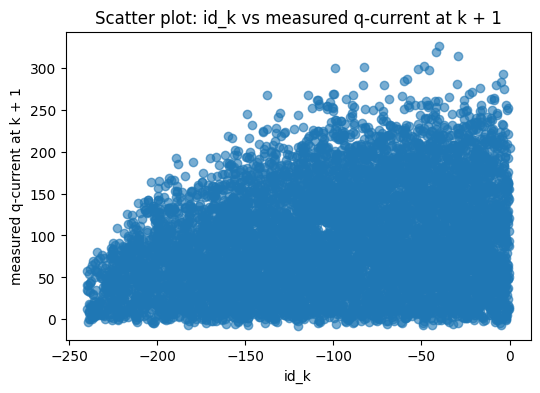

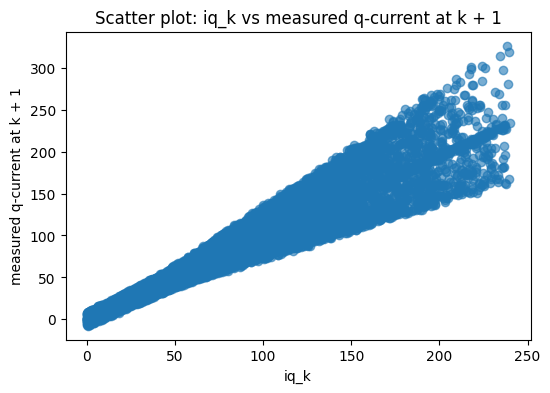

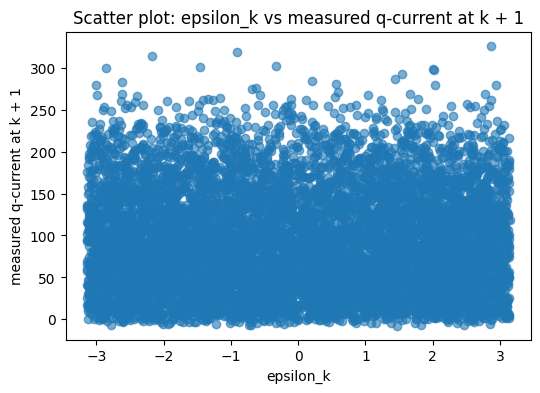

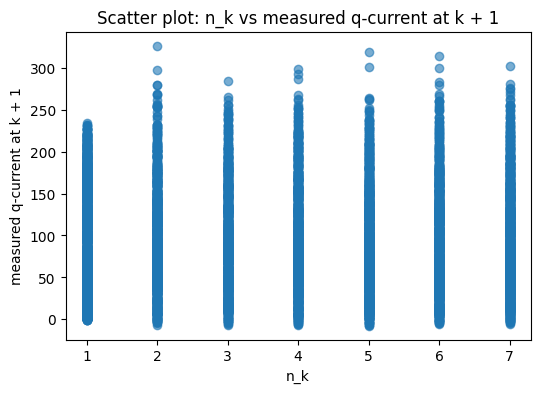

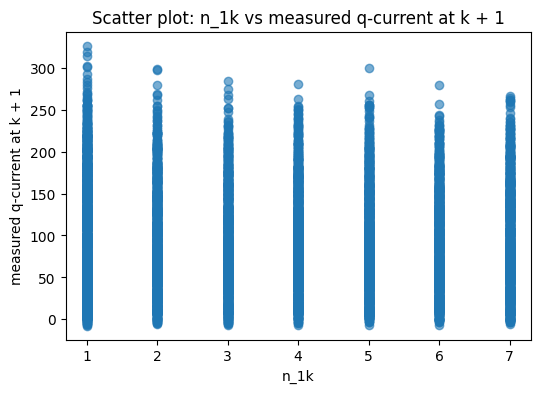

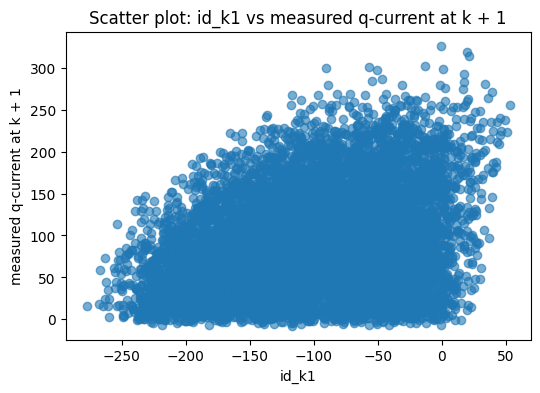

In [4]:
# Load the dataset
file_path = 'DatasetElectricMotor.csv'
data = pd.read_csv(file_path) # Use panda library to read csv file so I can add the x label in loop

# Seperate data into x and y components
X = data.iloc[:, :-1]  # To get range of columns
y = data.iloc[:, -1]    # y variable for all this is q_k1

# Loop to create graphs
num_columns = X.shape[1]
for i in range(num_columns):
    plt.figure(figsize=(6, 4))
    plt.scatter(X.iloc[:, i], y, alpha=0.6)
    plt.title(f'Scatter plot: {X.columns[i]} vs measured q-current at k + 1')
    plt.xlabel(X.columns[i])
    plt.ylabel('measured q-current at k + 1')
    plt.show()


Split the dataset randomly into training and testing sets such that the
training set comprises of 80% of the samples and the testing set comprises of
the remaining 20%. Hint: numpy’s arange and shuffle may be useful

In [5]:
data = pd.read_csv("DatasetElectricMotor.csv").to_numpy()  # Import data to numpy array for easier manipulation for this section

n_samples = data.shape[0]  # Get the number of rows in the dataset.
indices = np.arange(n_samples)  # Create an array of indices from 0 to n_samples-1.
np.random.shuffle(indices)

train_size = int(0.8 * n_samples)
train_indices = indices[:train_size]  # 80% of data for training

test_size = int(0.2 * n_samples)
test_indices = indices[:test_size]  # 80% of data for testing

train_data = data[train_indices]
test_data = data[test_indices]

# Check data if data got split
print(train_data.shape)
print(test_data.shape)
print(data.shape)


(6400, 7)
(1600, 7)
(8000, 7)


For each of the five features, perform linear regression on the training data
and use the trained model to infer the values of the testing data.

In [20]:
feature_names = ['id_k', 'iq_k', 'epsilon_k', 'n_k', 'n_1k']
results = {}

for i in range(len(feature_names)):
    x = train_data[:, i]  # Feature
    y = train_data[:, -1]  # q_k1

    A = np.column_stack((x, np.ones(x.shape[0])))
    theta, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    x_test = test_data[:, i]
    A_test = np.column_stack((x_test, np.ones(x_test.shape[0])))
    y_test_fit = A_test @ theta  # Predicted values for the test set

    # Store results
    results[feature_names[i]] = {
        'theta': theta,
        'y_test_fit': y_test_fit[:5]  # Showing first 5 predicted values
    }

# Display the results
for feature, result in results.items():
    print(f"Feature: {feature}")
    print(f"  Coefficients (theta): {result['theta']}")
    print(f"  Sample predicted values (test set): {result['y_test_fit']}")
    print()

Feature: id_k
  Coefficients (theta): [  0.25184205 119.45285075]
  Sample predicted values (test set): [118.41680051  78.19565801 111.63042261 105.46011862  88.34129127]

Feature: iq_k
  Coefficients (theta): [0.98057756 3.10607949]
  Sample predicted values (test set): [129.30572496  65.66728078  75.95556917  94.95170988  95.29121525]

Feature: epsilon_k
  Coefficients (theta): [-0.56202201 94.04700364]
  Sample predicted values (test set): [95.33135882 94.08435645 93.74892998 92.3269274  93.10028206]

Feature: n_k
  Coefficients (theta): [ 0.15889449 93.43555053]
  Sample predicted values (test set): [94.54781199 93.91223401 93.75333952 94.3889175  94.07112851]

Feature: n_1k
  Coefficients (theta): [-0.24762237 94.98431414]
  Sample predicted values (test set): [94.4890694  93.99382465 94.4890694  94.4890694  93.74620228]



For each feature, create a plot that scatters the observed training samples in
red, the observed testing samples in blue, and the inferred testing samples in
green.

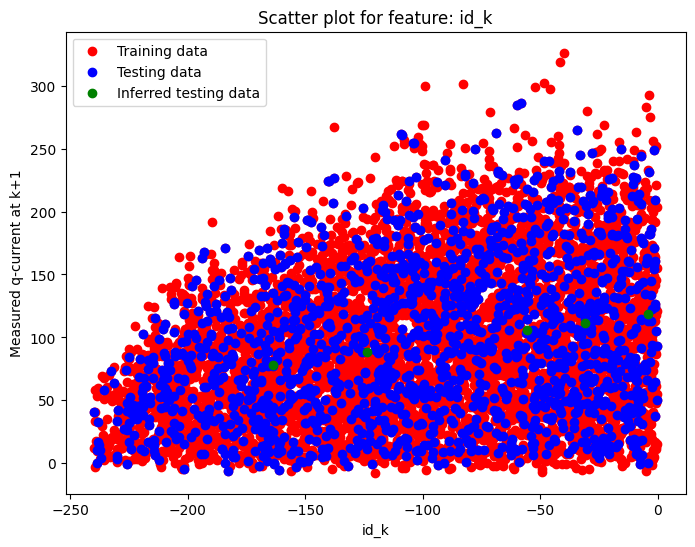

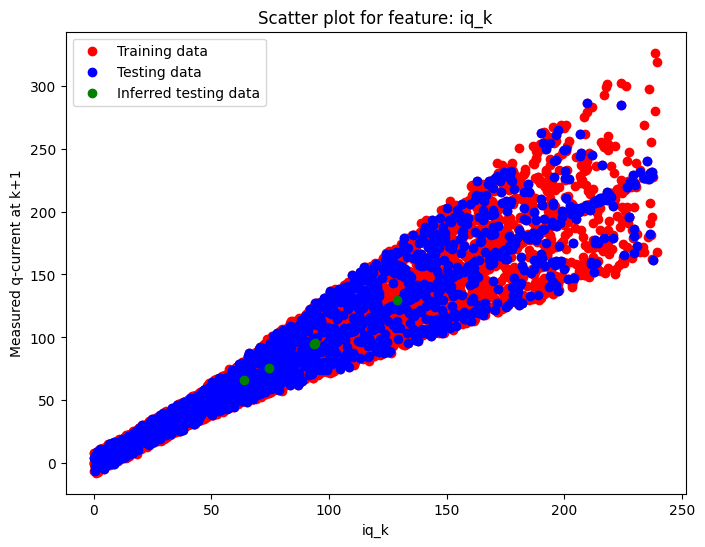

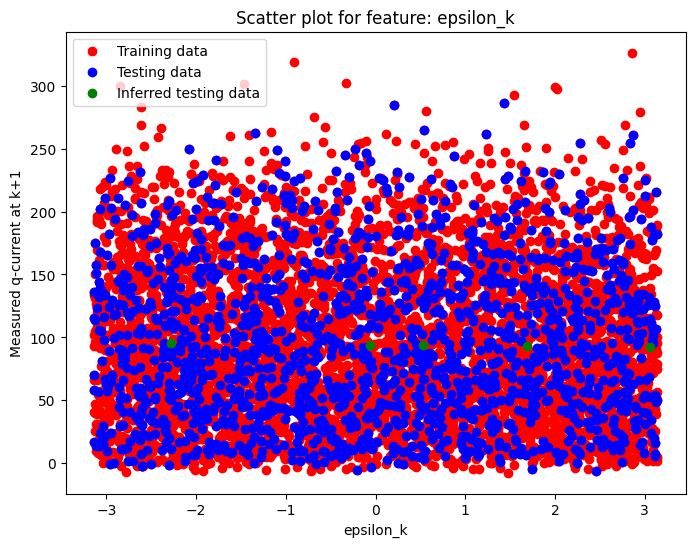

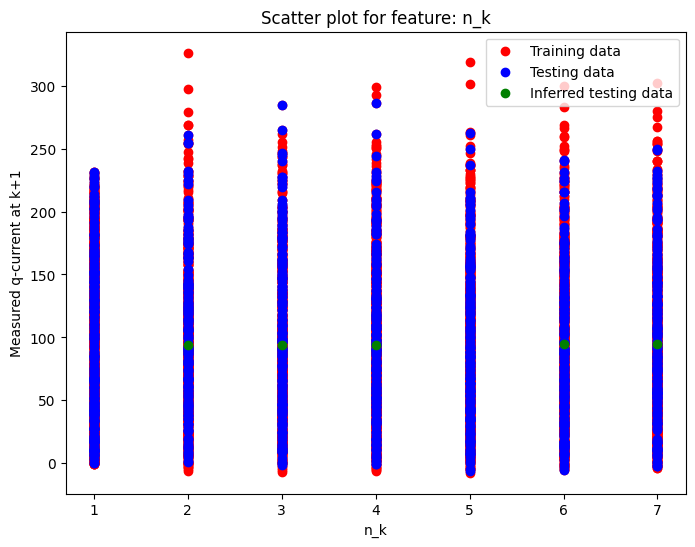

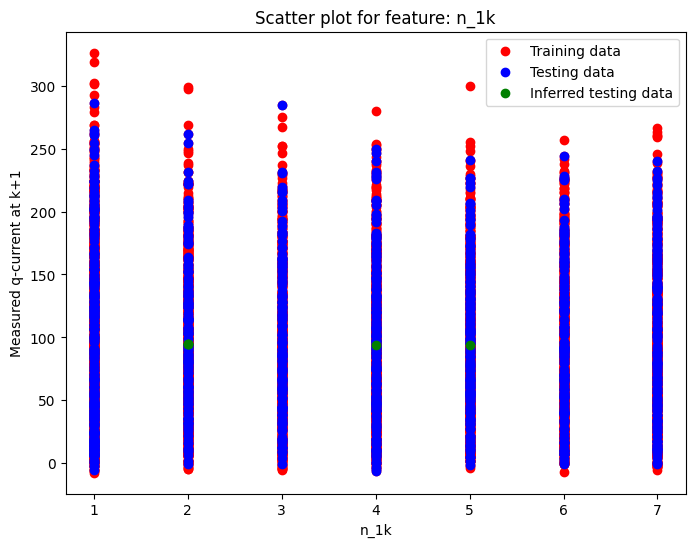

In [7]:
for i, feature in enumerate(feature_names):
    x_train = train_data[:, i]
    y_train = train_data[:, -1]  # q_k1

    x_test = test_data[:, i]
    y_test = test_data[:, -1]

    y_test_fit = results[feature]['y_test_fit']  # Inferred test values

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x_train, y_train, color='red', label='Training data')
    plt.scatter(x_test, y_test, color='blue', label='Testing data')
    plt.scatter(x_test[:len(y_test_fit)], y_test_fit, color='green', label='Inferred testing data')
    plt.title(f'Scatter plot for feature: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Measured q-current at k+1')
    plt.legend()
    plt.show()

Calculate the MSE on the testing samples for each feature.

In [21]:
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# mse values
mse_results = {}

for i, feature in enumerate(feature_names):
    x_test = test_data[:, i]
    y_test = test_data[:, -1]

    # Recalculate inferred test values for full set
    A_test = np.column_stack((x_test, np.ones(x_test.shape[0])))
    theta = results[feature]['theta']
    y_test_fit = A_test @ theta
    # Calculate mean squared error
    mse = calculate_mse(y_test, y_test_fit)
    mse_results[feature] = mse

# Display MSE for each feature
for feature, mse in mse_results.items():
    print(f"MSE for {feature}: {mse}")

MSE for id_k: 3418.71044013078
MSE for iq_k: 400.9966425289916
MSE for epsilon_k: 3673.0938668706617
MSE for n_k: 3671.190772934145
MSE for n_1k: 3669.9006245530018


In [9]:
best_feature = min(mse_results, key=mse_results.get)
print(f"The best performing feature is: {best_feature} with an MSE of {mse_results[best_feature]}")


The best performing feature is: iq_k with an MSE of 400.9966425289916


Using the feature deemed as producing the best model from before, preform regression for higher order polynomials from 1 to 10.

In [22]:
def polynomial_regression(x_train, y_train, x_test, degree):
    # Create the polynomial features
    poly_features = np.vander(x_train, degree + 1)
    theta, _, _, _ = np.linalg.lstsq(poly_features, y_train, rcond=None)
    poly_features_test = np.vander(x_test, degree + 1)
    y_test_pred = poly_features_test @ theta

    return y_test_pred


For each model, calculate MSE on the testing data. Plot the results and include them in your report.

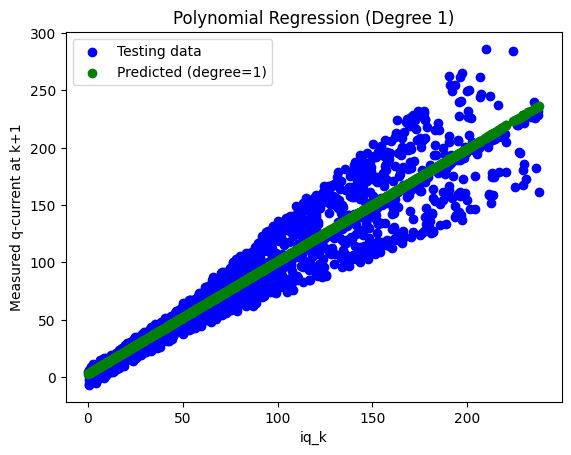

Degree 1, MSE: 400.9966425289916


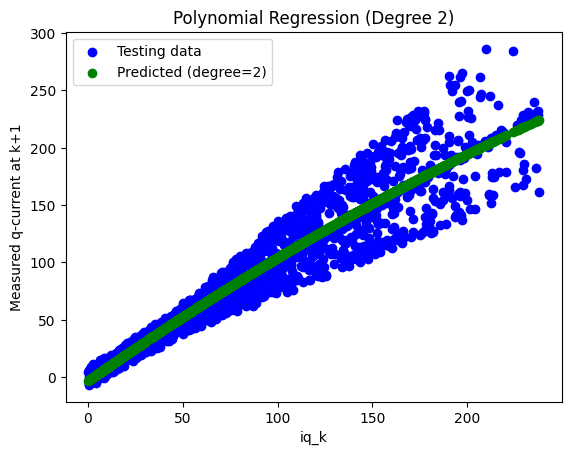

Degree 2, MSE: 389.0131073822742


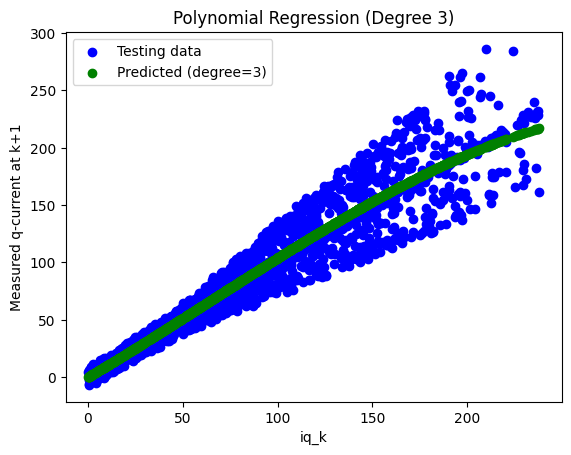

Degree 3, MSE: 386.82033775841717


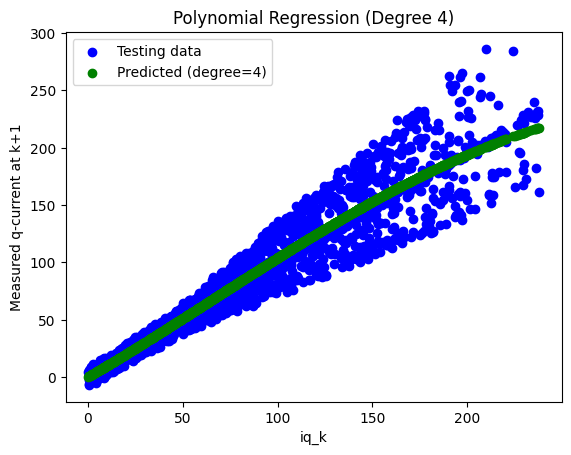

Degree 4, MSE: 386.79643337690794


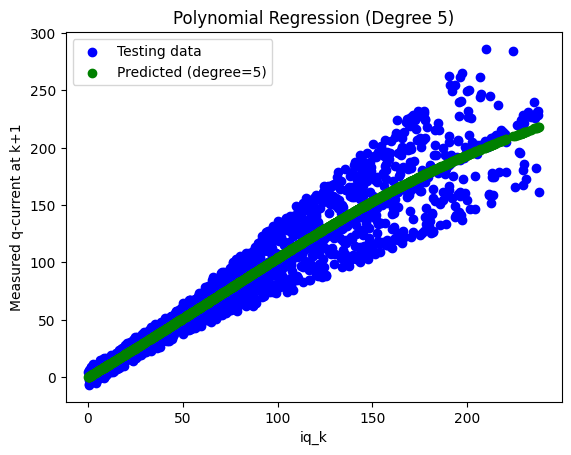

Degree 5, MSE: 387.03407584973974


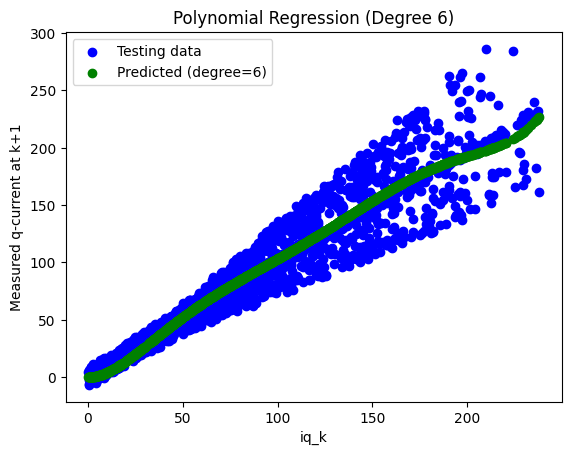

Degree 6, MSE: 394.8702550574324


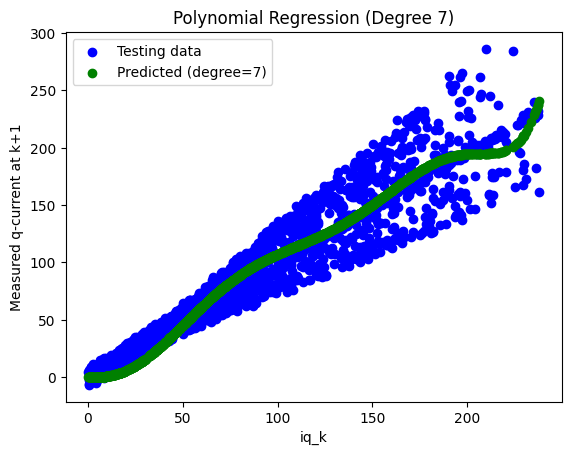

Degree 7, MSE: 431.2454201777463


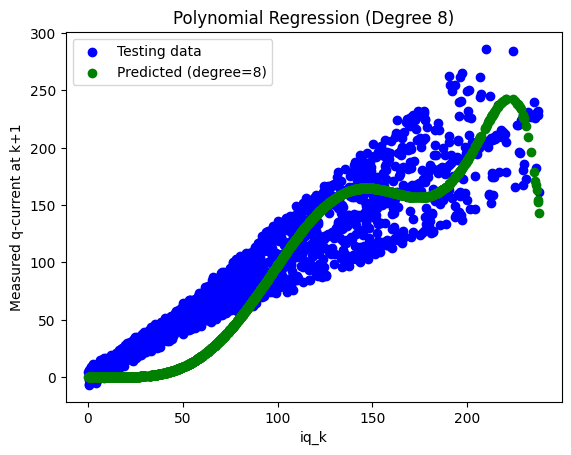

Degree 8, MSE: 1081.6373126211563


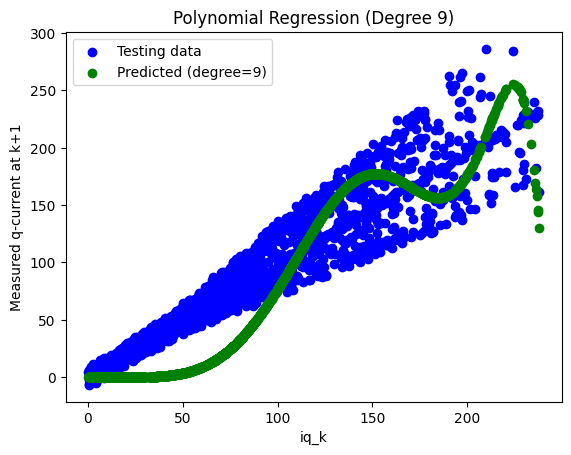

Degree 9, MSE: 1552.8196929389908


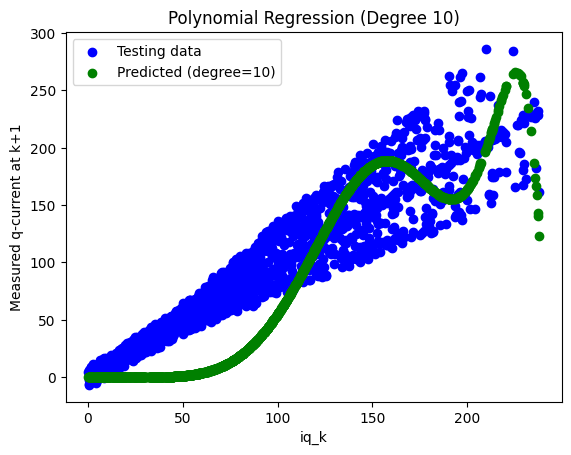

Degree 10, MSE: 2076.5000526878116


In [23]:
x_train = train_data[:, 1]  # iq_k
y_train = train_data[:, -1]  # iq_k1

x_test = test_data[:, 1]
y_test = test_data[:, -1]

# Perform polynomial regression for degrees 1 to 10 and calculate MSE
for degree in range(1, 11):
    y_test_pred = polynomial_regression(x_train, y_train, x_test, degree)

    # Calculate MSE for this degree
    mse = np.mean((y_test - y_test_pred) ** 2)

    # Plot the test data and predictions
    plt.scatter(x_test, y_test, color='blue', label='Testing data')
    plt.scatter(x_test, y_test_pred, color='green', label=f'Predicted (degree={degree})')
    plt.title(f'Polynomial Regression (Degree {degree})')
    plt.xlabel('iq_k')
    plt.ylabel('Measured q-current at k+1')
    plt.legend()
    plt.show()

    print(f'Degree {degree}, MSE: {mse}')


For each model, calculate the Akaike Information Criterion(AIC) using the MSE of the training data. Plot the results and include them in your report. N is the number of sample, K is the model order.

Degree 1, AIC: -17795.707836537167
Degree 2, AIC: -17947.17146879473
Degree 3, AIC: -17977.368266522408
Degree 4, AIC: -17975.52710489269
Degree 5, AIC: -17973.86134223284
Degree 6, AIC: -17857.78913248571
Degree 7, AIC: -17175.934553289804
Degree 8, AIC: -11412.302601387151
Degree 9, AIC: -9173.857984519855
Degree 10, AIC: -7331.510849154964


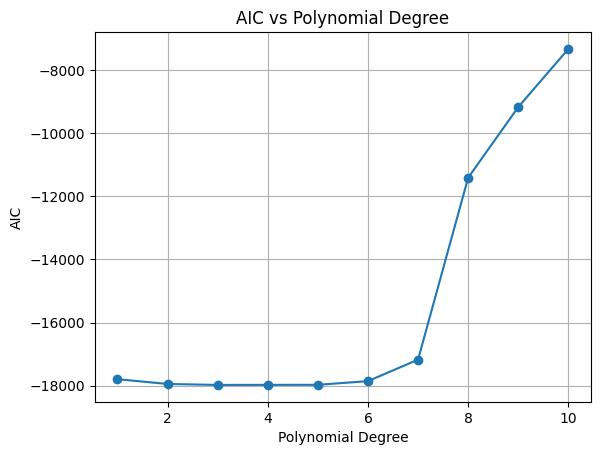

In [24]:
N = len(y_train)  # Number of samples
aic_values = []  # Store AIC


# Perform polynomial regression for degrees 1 to 10 and calculate AIC
for degree in range(1, 11):
    y_train_pred = polynomial_regression(x_train, y_train, x_train, degree)
    mse = np.mean((y_train - y_train_pred) ** 2)

    # Calculate the number of parameters (degree + 1)
    K = degree + 1

    # Calculate AIC
    aic = N * np.log(mse / N) + 2 * K
    aic_values.append(aic)

    print(f'Degree {degree}, AIC: {aic}')

# Plot AIC values
plt.plot(range(1, 11), aic_values, marker='o')
plt.title('AIC vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('AIC')
plt.grid(True)
plt.show()


Implement PCA in Python on the Mice Protein Expression dataset. Do not use any of Python’s PCA functions. Reduce the dimensionality to two dimensions. In other words, use the two principal components which cumulatively explain the most variance.

In [13]:
# Load the dataset
file_path = '/content/MiceProteinExpressionDataset.csv'
data = pd.read_csv(file_path)

In [25]:
# Code doesn't work without this, used to change the NaN sections
numeric_data = data.select_dtypes(include=[np.number])
numeric_data = numeric_data.fillna(numeric_data.mean())

# Standardize the dataset
mean = np.mean(numeric_data, axis=0)
std = np.std(numeric_data, axis=0)
standardized_data = (numeric_data - mean) / std
cov_matrix = np.cov(standardized_data, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix) # eigenvectors and eigenvalues from the covariance matrix

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Project the data into a lower-dimensional space
n_components = 2
principal_components = sorted_eigenvectors[:, :n_components]
projected_data = np.dot(standardized_data, principal_components)

# Display the data
projected_df = pd.DataFrame(projected_data, columns=[f'PC{i+1}' for i in range(n_components)])
print(projected_df.head())


        PC1       PC2
0  4.638488 -4.510792
1  2.923382 -4.490331
2  3.024374 -4.610073
3  0.752140 -3.056439
4 -0.464471 -3.246724


Plot the dataset after applying this PCA procedure in two dimensions.

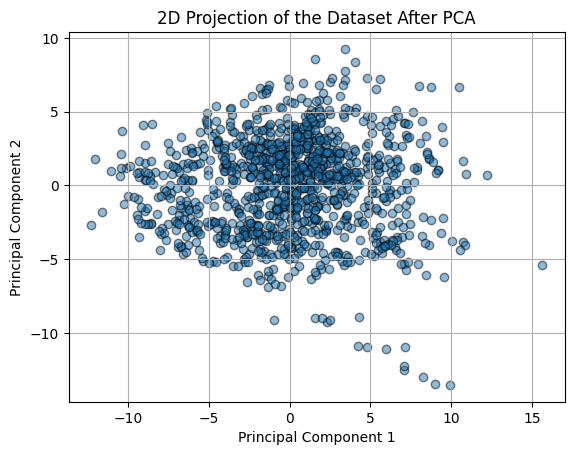

In [26]:
# Plot the dataset after applying PCA in two dimensions
plt.scatter(projected_data[:, 0], projected_data[:, 1], alpha=0.5, edgecolors='k')
plt.title("2D Projection of the Dataset After PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

How much variance is explained by the two largest principal components?

In [16]:
explained_variances = eigenvalues / np.sum(eigenvalues)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_explained_variances = explained_variances[sorted_indices]

# Calculate the cumulative variance explained by the top two components
variance_explained_by_two = sorted_explained_variances[:2].sum()

print(f"Variance explained by the two largest principal components: {variance_explained_by_two:.4f}")


Variance explained by the two largest principal components: 0.4362


How many principal components need to be used to explain 98% of the
variance?

In [28]:
explained_variances = eigenvalues / np.sum(eigenvalues)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_explained_variances = explained_variances[sorted_indices]
cumulative_variance = np.cumsum(sorted_explained_variances)

# Find the number of components needed to explain 98% of the variance
components_needed = np.argmax(cumulative_variance >= 0.98) + 1  # Add 1 because np.argmax gives the index

print(f"Number of principal components needed to explain 98% of the variance: {components_needed}")

Number of principal components needed to explain 98% of the variance: 41
